<a href="https://colab.research.google.com/github/JyotiRawat29/MastersThesis/blob/main/CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchinfo
import numpy as np
import torch
from torch import Tensor
import torch.nn.functional as f
from torch import nn
import scipy.io as sio
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from multiprocessing import cpu_count
import torch.nn.functional as F
import torch.optim as optim

from google.colab import drive
import tensorflow as tf
from tensorflow import summary
import matplotlib.pyplot as plt

from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
!pip install torchinfo

from torchinfo import summary
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from torch.utils.tensorboard import SummaryWriter


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
writer = SummaryWriter()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.cuda.empty_cache()
#load the ECG file
src_dataset = sio.loadmat('/content/drive/MyDrive/ECG2(withDA).mat')
#load the labels
label=pd.read_csv('/content/drive/MyDrive/label.csv',header=None)

In [ ]:
#print(src_dataset)
testdata = src_dataset['ECG'] # use the key for data here
X=testdata['Data']

In [ ]:
X=np.array(X[0])
X = np.vstack(X[:,]).astype(np.float)


In [ ]:
#X=torch.from_numpy(X)

In [ ]:
label=np.array(label, dtype=object)
label=np.array(label)
label= np.vstack(label[:,]).astype(np.float)


In [ ]:
X = torch.from_numpy(X)
Y = torch.from_numpy(label)

** PRE-PROCESSING OF THE DATA**

In [ ]:
from sklearn.preprocessing import normalize

In [ ]:
X= X/np.linalg.norm(X) 

**OVERSAMPLING**

In [ ]:
smote = SMOTE()

In [ ]:
x_smote, y_smote = smote.fit_resample(X, label)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X = torch.from_numpy(x_smote)
Y = torch.from_numpy(y_smote)

In [ ]:
X.shape

torch.Size([1500, 4000])

**CNN_LSTM**

In [ ]:
def create_datasets(X, Y):
    print("len of X and Y is",X.shape,Y.shape)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify = Y) 
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.25, stratify = Y_train) 
    #squeeze labelled data to make it 1 dimension array
    
    Y_train=torch.squeeze(Y_train)
    Y_valid=torch.squeeze(Y_valid)
    Y_test=torch.squeeze(Y_test)

    print("X_train, X_valid, X_test shape before list comprehension",X_train.shape, X_valid.shape, X_test.shape)
    print("X_train, X_valid, X_test dtype before list comprehension",X_train.dtype, X_valid.dtype, X_test.dtype)
    print("Y_train, Y_valid, Y_test dtype before list comprehension",Y_train.dtype, Y_valid.dtype, Y_test.dtype)
    #the tensors created have dtype float64 but the models have dtypes float32 and its easier to change dtypes of the tensors instead of a model
   
    X_train, X_valid, X_test = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid,X_test)]
    Y_train, Y_valid,Y_test = [torch.tensor(arr, dtype=torch.long) for arr in (Y_train, Y_valid,Y_test)]
    print("X_train, X_valid, X_test shape after list comprehension",X_train.shape, X_valid.shape, X_test.shape)
    print("X_train, X_valid, X_test dtype before list comprehension",X_train.dtype, X_valid.dtype, X_test.dtype)
    print("Y_train, Y_valid, Y_test dtype before list comprehension",Y_train.dtype, Y_valid.dtype, Y_test.dtype)
    #convert training and testing data into Tensor Dataset
    
    train_ds = TensorDataset(X_train, Y_train)
    valid_ds = TensorDataset(X_valid, Y_valid)
    test_ds = TensorDataset(X_test,Y_test)
    print("train_ds, valid_ds, test_ds length of datasets respectively",len(train_ds), len(valid_ds), len(test_ds))
    return train_ds, valid_ds,test_ds

In [ ]:
def create_loaders(train_ds, valid_ds,test_ds, bs, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=True, num_workers=jobs)
    test_dl = DataLoader(test_ds, bs, shuffle=True, num_workers=jobs)
    print("lenth of data loaders train_dl, valid_dl, test_dl",len(train_dl), len(valid_dl), len(test_dl))
    return train_dl, valid_dl, test_dl

In [ ]:
def accuracy(output, target):
    return (output.argmax(dim=1) == target).float().mean().item()

In [ ]:
train_ds, val_ds, test_data = create_datasets(X, Y)

len of X and Y is torch.Size([1273, 4000]) torch.Size([1273, 1])
X_train, X_valid, X_test shape before list comprehension torch.Size([763, 4000]) torch.Size([255, 4000]) torch.Size([255, 4000])
X_train, X_valid, X_test dtype before list comprehension torch.float64 torch.float64 torch.float64
Y_train, Y_valid, Y_test dtype before list comprehension torch.float64 torch.float64 torch.float64
X_train, X_valid, X_test shape after list comprehension torch.Size([763, 4000]) torch.Size([255, 4000]) torch.Size([255, 4000])
X_train, X_valid, X_test dtype before list comprehension torch.float32 torch.float32 torch.float32
Y_train, Y_valid, Y_test dtype before list comprehension torch.int64 torch.int64 torch.int64
train_ds, valid_ds, test_ds length of datasets respectively 763 255 255


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
bs = 32
train_dl, valid_dl,test_data = create_loaders(train_ds, val_ds,test_data, bs, jobs=cpu_count())

lenth of data loaders train_dl, valid_dl, test_dl 24 8 8


In [ ]:


input_dim = 1
hidden_dim = 4000
output_cnn = 100
layer_dim = 1
output_dim = 3
seq_dim = 4000
lr = 0.0001

n_epochs = 101
# iterations_per_epoch = len(train_dl)
best_acc = 0
patience, trials = 100, 0




In [ ]:
class LSTM_CNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,output_channels=1):
    super(LSTM_CNN, self).__init__()
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim
    self.cnn1 = nn.Conv1d(1,1, kernel_size=4, padding='valid')
    self.cnn2 = nn.Conv1d(1,1, kernel_size=4, padding='valid')
    self.cnn3 = nn.Conv1d(1,1, kernel_size=4, padding='valid')
    self.cnn4 = nn.Conv1d(1,1, kernel_size=4, padding='valid')
    self.fc = nn.Linear(120, 100)
    self.flat = nn.Flatten()
    self.maxP1 = nn.MaxPool1d(4)
    self.maxP2 = nn.MaxPool1d(4)
    self.maxP3 = nn.MaxPool1d(2)

    self.lstm = nn.LSTM(100, 10, 2, batch_first=True)
    self.fc1 = nn.Linear(10, output_dim)
    self.softmax = nn.Softmax(dim=1)
    self.batch_size = None
    self.hidden = None
  
  def forward(self, x):
    h0, c0 = self.init_hidden(x)
    out = self.cnn1(x) # 3997
    out = self.maxP1(out) # 999
    out = self.cnn2(out) # 996
    out = self.maxP2(out) # 249
    out = self.cnn3(out) # 246
    out = self.maxP3(out) # 123
    out = self.cnn4(out) # 120
    # out = self.flat(out)
    out = self.fc(out) # 100
    out, (hn, cn) = self.lstm(out, (h0, c0))
    out = self.flat(out)
    out = self.fc1(out)
    out = self.softmax(out)
    return out
  
  def init_hidden(self, x):
    h0 = torch.zeros(2, x.size(0), 10)
    c0 = torch.zeros(2, x.size(0), 10)
    #print("h0 size in init function",h0.size())
    return [t.to(device) for t in (h0, c0)]

In [ ]:
model = LSTM_CNN(input_dim,hidden_dim,layer_dim,output_dim)
model = model.to(device)
summary(model, (1,1,4000))
# print(model)

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_CNN                                 --                        --
├─Conv1d: 1-1                            [1, 1, 3997]              5
├─MaxPool1d: 1-2                         [1, 1, 999]               --
├─Conv1d: 1-3                            [1, 1, 996]               5
├─MaxPool1d: 1-4                         [1, 1, 249]               --
├─Conv1d: 1-5                            [1, 1, 246]               5
├─MaxPool1d: 1-6                         [1, 1, 123]               --
├─Conv1d: 1-7                            [1, 1, 120]               5
├─Linear: 1-8                            [1, 1, 100]               12,100
├─LSTM: 1-9                              [1, 1, 10]                5,360
├─Flatten: 1-10                          [1, 10]                   --
├─Linear: 1-11                           [1, 3]                    33
├─Softmax: 1-12                          [1, 3]                    --
Total params

In [ ]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

In [ ]:
import copy

In [ ]:
history = dict(train =[], val = [])
best_loss = 1
act =[]
pred = []
n_epochs = 100
best_model_wts = copy.deepcopy(model.state_dict())
for epoch in range(1, n_epochs+1):
  train_losses = []
  val_losses = []
  print(f'training loop :: epoch is {epoch}')
  for x_batch,y_batch in train_dl:
    
    model.train()
    x_batch = x_batch.unsqueeze(1)
    optimizer.zero_grad()
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    out = model(x_batch)
    loss = criteria(out,y_batch)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    #if i % 5 == 0:
     # print("iteration %d, epochs %d,loss = %.4f" %(i,epochs,loss.item()))
#VALIDATION LOOP
    model.eval()
    correct, total = 0, 0
    y_class = []
    pred_class = []
  with torch.no_grad():
    print(f'validation loop :: epoch is {epoch}')
    for x_val,y_val in valid_dl:
      
      model.eval()
      x_val, y_val = [t for t in (x_val, y_val)]
      x_val = x_val.to(device)
      y_val = y_val.to(device)

      x_val =x_val.unsqueeze(1)
      optimizer.zero_grad()

      out = model(x_val)
      loss_val = criteria(out,y_val)
      val_losses.append(loss_val.item())
      preds = F.log_softmax(out, dim=1).argmax(dim=1)
      total += y_val.size(0)
      correct += (preds == y_val).sum().item()
      #print("preds", pred)
      #print("y_val",y_val)

  train_loss = np.mean(train_losses)
  val_loss = np.mean(val_losses)
  acc = correct / total
  y_class+=y_val.tolist()
  pred_class+=preds.tolist()
  act.append(y_class)
  pred.append(pred_class)
  history['train'].append(train_loss)
  history['val'].append(val_loss)

    
  print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

  if acc > best_acc:
    trials = 0
    best_acc = acc
    torch.save(model.state_dict(), 'best.pth')
    print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')

  writer.flush()
  writer.add_graph(model,x_batch)
  writer.close()
  model.load_state_dict(best_model_wts)


training loop :: epoch is 1
validation loop :: epoch is 1
Epoch:   1. Loss: 1.0953. Acc.: 39.22%
training loop :: epoch is 2
validation loop :: epoch is 2
Epoch:   2. Loss: 1.1018. Acc.: 39.22%
training loop :: epoch is 3
validation loop :: epoch is 3
Epoch:   3. Loss: 1.0972. Acc.: 39.22%
training loop :: epoch is 4
validation loop :: epoch is 4
Epoch:   4. Loss: 1.0972. Acc.: 39.22%
training loop :: epoch is 5
validation loop :: epoch is 5
Epoch:   5. Loss: 1.0972. Acc.: 39.22%
training loop :: epoch is 6
validation loop :: epoch is 6
Epoch:   6. Loss: 1.0971. Acc.: 39.22%
training loop :: epoch is 7
validation loop :: epoch is 7
Epoch:   7. Loss: 1.0989. Acc.: 39.22%
training loop :: epoch is 8
validation loop :: epoch is 8
Epoch:   8. Loss: 1.0977. Acc.: 39.22%
training loop :: epoch is 9
validation loop :: epoch is 9
Epoch:   9. Loss: 1.0982. Acc.: 39.22%
training loop :: epoch is 10
validation loop :: epoch is 10
Epoch:  10. Loss: 1.0954. Acc.: 39.22%
training loop :: epoch is 11

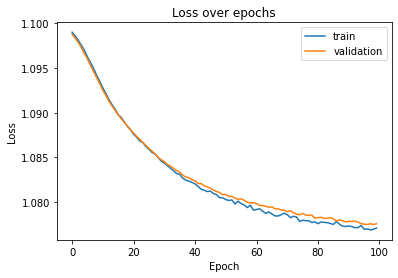

In [ ]:

ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.title('Loss over epochs')
#plt.show()
plt.savefig('Loss_over_epochs.png')


In [ ]:
act =np.array(act)
act= act.reshape(3100)

In [ ]:
pred = np.array(pred)
pred = pred.reshape(3100)

In [ ]:
f1_score(act, pred, average='macro')

0.18436406067677946

In [ ]:
conf_matrix = confusion_matrix(y_true=act, y_pred=pred)

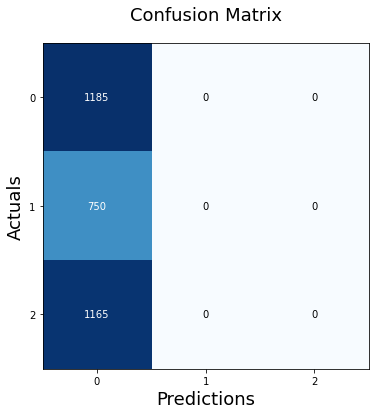

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

**PREDICTION**

In [ ]:
test_dl = DataLoader(test_data, batch_size=64, shuffle=False)
y_classif = []
predict_classif = []
correct = 0
total = 0
print('Predicting on test dataset')
model = model.to(device)
with torch.no_grad():
  for data in test_data:
    x,y = data
    #print("x",x)
    x = x.to(device)
    y = y.to(device)
    x=torch.unsqueeze(x,1)
    out = model.train()(x)
    _,predicted = torch.max(out.data,1)
    total += y.size(0)
    correct += (predicted==y).sum().item()
    #print(f'y{y}')
    #print(f'predicted{predicted}')
    y_classif +=y.tolist()
    predict_classif +=predicted.tolist()

#print("y_classif",y_classif)
#print("predict_classif",predict_classif)
f1 =f1_score(y_classif, predict_classif, average='macro')
print(f'f1 score is {f1}')

print("accuracy on test %d %%" % (100 * correct / total), )

Predicting on test dataset
f1 score is 0.18779342723004697
accuracy on test 39 %


In [ ]:
conf_matrix = confusion_matrix(y_true=y_classif, y_pred=predict_classif)

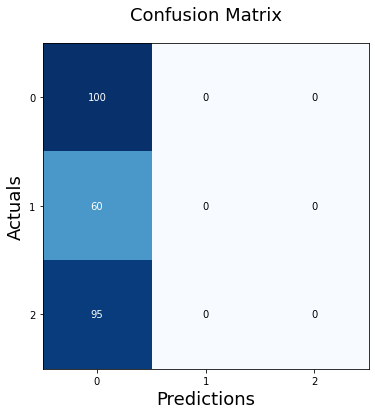

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()